# Walkthrough

We walk through the same components in the [Quickstart](quickstart.ipynb), to give more detail as to what the choices mean.

## Problem definition

We show how to use the basic user interface for Nested Slice Sampling. We will set up a 20D problem involving a multivariate unit Gaussian $\mathcal{N}(0,\mathbf{I})$ prior, and a multivariate Gaussian likelihood with a randomized mean and covariance. The resulting posterior and normalizing constant is analytically known.

In [1]:
import jax
import jax.numpy as jnp
import tqdm

import blackjax

rng_key = jax.random.PRNGKey(0)

d = 20

C = jax.random.normal(rng_key, (d, d)) * 0.1
like_cov = C @ C.T
like_mean = jax.random.normal(rng_key, (d,))

prior_mean = jnp.zeros(d)
prior_cov = jnp.eye(d) * 1


## Components needed

In a similar style to Sequential Monte Carlo methods available within `blackjax`, We need to declare three pieces to compose the sampling algorithm
- A (log) prior density
- A (log) likelihood function
- An initial population of particles, drawn from the prior. This will remain fixed throughout a run, so the size of this population is a hyperparameter of the algorithm, we will call this `n_live`

In [2]:
logprior_density = lambda x: jax.scipy.stats.multivariate_normal.logpdf(
    x, prior_mean, prior_cov
)

loglikelihood_function = lambda x: jax.scipy.stats.multivariate_normal.logpdf(
    x, like_mean, like_cov
)

rng_key, prior_sample_key = jax.random.split(rng_key)
n_live = 1000
initial_population = jax.random.multivariate_normal(
    prior_sample_key, prior_mean, prior_cov, (n_live,)
)

## Algorithm definition

We have already implicitly set one hyperparameter we need, `n_live`, the remaining ones to set are

- `num_mcmc_steps` -- the length of the short Markov chains used to update the population, typically set to some multiple of the dimension of the parameter space, $3 \times d$ is a good starting point
- `n_delete` -- some integer $\in [1, n_\mathrm{live} -1]$, how many chains to vectorize over, setting this to approximately 10% of `n_live` is likely good for CPU usage, Up to 50% for GPU.

`nss` is defined as a top level API in the `blackjax` library, initialising this function returns a `blackjax.SamplingAlgorithm`. This base type defines the two pieces needed to build a sampling algorithm,
- `init` -- A function to initialise `NSState` from particle positions
- `step` -- A function to evolve the `NSState` population one step

In [3]:
num_mcmc_steps = 3 * d
n_delete = int(n_live*0.1)

algo = blackjax.ns.adaptive.nss(
    logprior_fn=logprior_density,
    loglikelihood_fn=loglikelihood_function,
    n_delete=n_delete,
    num_mcmc_steps=num_mcmc_steps,
)

state = algo.init(initial_population, loglikelihood_function)


The state is constructed as a `NamedTuple`, consisting of a `sampler_state` and a `parameter_override`
- `state.sampler_state` is the core `NSState` named tuple as defined in `blackjax.ns.base`, containing attributes such as `particles`, `logL` -- the log likelihood values associated to each particle, `logZ` -- the estimate of the log marginal likelihood, this is the primary quantitity we want to converge.
- `parameter_override` is the inner kernel tuning parameters following `blackjax.ns.adaptive`, in the case of `nss` we specifically hard code a multivariate Gaussian as the parameter to be tuned

Iteratively updating the state using `algo.step` is a nested sampling algorithm. To do parameter estimation we need to track what we left behind, another `NamedTuple` this time `NSInfo`. The quantity we read out is the accumulation of many `NSInfo` tuples associated with each state transition.

Following the general design pattern of `blackjax`, we set up a compilable `one_step` wrapping around the `algo.step`.

In [4]:
@jax.jit
def one_step(carry, xs):
    state, k = carry
    k, subk = jax.random.split(k, 2)
    state, dead_point = algo.step(subk, state)
    return (state, k), dead_point

If we know how many steps to take we can now `jax.lax.scan` over this, compose some larger number of steps etc. As we won't in general know how many steps we need, and we need to save every `NSInfo`, we will use a python outer loop. Any inefficiency of this can be lifted by scanning over some multiple of `one_step` to build a coarser step in python.

## A nested sampling run
We will assess whether we have run enough steps of sampling dynamically by checking some properties of the sample state. In this example we will follow conventions of the PolyChord implementation {cite}`Handley_2015`, and check when the remaining live evidence is less than $1e^{-3}$ of the running estimate.

In [5]:
dead = []

with tqdm.tqdm(desc="Dead points", unit=" dead points") as pbar:
    while not state.sampler_state.logZ_live - state.sampler_state.logZ < -3:
        (state, rng_key), dead_info = one_step((state, rng_key), None)
        dead.append(dead_info)
        pbar.update(n_delete)

Dead points: 41500 dead points [00:10, 3865.46 dead points/s]


## Utilities
As the calculation is a little unusual, paying little attention to the final state, and more to the discarded infos, we include some utils to do common manipulations

- `finalise` -- For correctness the final state should be "killed" and rendered as an info, a crude function to do this compresses the list of `dead` and the final `state` into a single cohesive `NSInfo`
- `log_weights` -- compute posterior point weights from `NSInfo`, this should reconstruct the normalising constant, typically used in conjunction with `finalise`
- `sample` -- draw "equal weight" posterior samples from `NSInfo`
- `ess` -- simply get an estimate of the Effective Sample Size, useful to know how many posterior points you can roughly usefully sample

In [6]:
from blackjax.ns.utils import log_weights, finalise, sample, ess

rng_key, weight_key, sample_key = jax.random.split(rng_key,3)
final_state = finalise(state,dead)
log_w = log_weights(weight_key, final_state, samples=100)
samples = sample(sample_key, final_state, n = n_live)
ns_ess = ess(sample_key, final_state)

logzs = jax.scipy.special.logsumexp(log_w, axis=0)

We can compare our estimate of the normalizing constant and use the samples to construct any useful posterior estimates

In [7]:
from jax.scipy.linalg import solve_triangular, cho_solve

def compute_logZ(mu_L, Sigma_L, logLmax=0, mu_pi=None, Sigma_pi=None):
    """
    Compute log evidence, posterior covariance, and posterior mean.
    
    Args:
        mu_L: Likelihood mean
        Sigma_L: Likelihood covariance
        logLmax: Maximum log likelihood value
        mu_pi: Prior mean
        Sigma_pi: Prior covariance
    
    Returns:
        Tuple of (log evidence, posterior covariance, posterior mean)
    """
    # Use Cholesky decomposition for more stable calculations
    L_pi = jnp.linalg.cholesky(Sigma_pi)
    L_L = jnp.linalg.cholesky(Sigma_L)
    
    # Compute precision matrices (inverse covariances)
    prec_pi = cho_solve((L_pi, True), jnp.eye(L_pi.shape[0]))
    prec_L = cho_solve((L_L, True), jnp.eye(L_L.shape[0]))
    
    # Compute posterior precision and its Cholesky factor
    prec_P = prec_pi + prec_L
    L_P = jnp.linalg.cholesky(prec_P)
    
    # Compute Sigma_P using Cholesky factor
    Sigma_P = cho_solve((L_P, True), jnp.eye(L_P.shape[0]))
    
    # Compute mu_P more stably
    b = cho_solve((L_pi, True), mu_pi) + cho_solve((L_L, True), mu_L)
    mu_P = cho_solve((L_P, True), b)
    
    # Compute log determinants using Cholesky factors
    logdet_Sigma_P = -2 * jnp.sum(jnp.log(jnp.diag(L_P)))
    logdet_Sigma_pi = 2 * jnp.sum(jnp.log(jnp.diag(L_pi)))
    
    # Compute quadratic forms using Cholesky factors
    diff_pi = mu_P - mu_pi
    diff_L = mu_P - mu_L
    quad_pi = jnp.sum(jnp.square(solve_triangular(L_pi, diff_pi, lower=True)))
    quad_L = jnp.sum(jnp.square(solve_triangular(L_L, diff_L, lower=True)))
    
    return (
        (
            logLmax
            + logdet_Sigma_P / 2
            - logdet_Sigma_pi / 2
            - quad_pi / 2
            - quad_L / 2
        ),
        Sigma_P,
        mu_P,
    )

log_analytic_evidence, post_cov, post_mean = compute_logZ(
    like_mean,
    like_cov,
    mu_pi=prior_mean,
    Sigma_pi=prior_cov,
    logLmax=loglikelihood_function(like_mean),
)

In [8]:
print(f"ESS: {int(ns_ess)}")
print(f"logZ estimate: {logzs.mean():.2f} +- {logzs.std():.2f}")
print(f"analytic logZ: {log_analytic_evidence:.2f}")

ESS: 9936
logZ estimate: -32.75 +- 0.19
analytic logZ: -32.83


Lastly we can use the particles themselves to do parameter inference, lets look at the first corner of our 20D parameter space

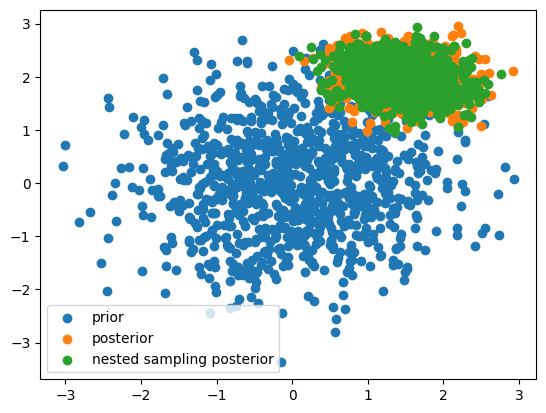

In [9]:
import matplotlib.pyplot as plt

posterior_truth = jax.random.multivariate_normal(
    rng_key, post_mean, post_cov, (n_live,)
)

plt.scatter(
    initial_population[..., 0], initial_population[..., 1], label="prior"
)
plt.scatter(
    posterior_truth[..., 0], posterior_truth[..., 1], label="posterior"
)
plt.scatter(
    samples[..., 0], samples[..., 1], label="nested sampling posterior"
)
plt.legend()